<a href="https://colab.research.google.com/github/TingyiWei2024/GNN_chemicalENV/blob/main/datainput_12_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/TingyiWei2024/GNN_chemicalENV.git

!ls -R GNN_chemicalENV


Cloning into 'GNN_chemicalENV'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 76 (delta 9), reused 63 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 2.27 MiB | 2.70 MiB/s, done.
Resolving deltas: 100% (9/9), done.
GNN_chemicalENV:
'DATA input'   datainput12_7.ipynb   README.md

'GNN_chemicalENV/DATA input':
 alfabet_Tatal20_results.xlsx   CCCC.xlsx   datainput12.6.py  'input 11.30.ipynb'


In [2]:

import pandas as pd

# Provide the correct path to your Excel file
file_path = "GNN_chemicalENV/DATA input/CCCC.xlsx"

# Load the Excel file
data = pd.read_excel(file_path)

# Display the first few rows of the data
print(data.head())
print(data.columns)



   Unnamed: 0                                           molecule  bond_index  \
0           0  CCCC[C@@H]1[C@@H](C)CC[C@H]2[C@@]1(C)CC[C@H]1C...          10   
1           1  CCCC[C@@H]1[C@@H](C)CC[C@H]2[C@@]1(C)CC[C@H]1C...          21   
2           2  CCCC[C@@H]1[C@@H](C)CC[C@H]2[C@@]1(C)CC[C@H]1C...          15   
3           3  CCCC[C@@H]1[C@@H](C)CC[C@H]2[C@@]1(C)CC[C@H]1C...           3   
4           4  CCCC[C@@H]1[C@@H](C)CC[C@H]2[C@@]1(C)CC[C@H]1C...           2   

  bond_type                                          fragment1  \
0       C-C  CCCC[C@H]1[C]2CC[C@H]3C(C)(C)CCC[C@]3(C)[C@H]2...   
1       C-C  CCCC[C@@H]1[C@@H](C)CC[C@@H]2[C]3CCCC(C)(C)[C@...   
2       C-C  CCCC[C@@H]1[C@@H](C)CC[C@H]2[C@@]1(C)CC[C@H]1[...   
3       C-C                                           [CH2]CCC   
4       C-C                                            [CH2]CC   

                                           fragment2  is_valid_stereo  \
0                                              [C

In [4]:
! pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 61.2 MB/s eta 0:00:00


In [6]:
def check_stereocenters(molecule: Type[Molecule]) -> bool:
    """
    Check the given molecule to determine whether valid stereochemistry exists.

    Parameters:
    molecule (Molecule): The molecule to check.

    Returns:
    bool: True if stereochemistry is valid, False otherwise.
    """
    stereocenters = count_stereocenters(molecule)
    if stereocenters["bond_unassigned"] > 0:
        return False

    max_unassigned = 1 if stereocenters["atom_assigned"] == 0 else 1
    return stereocenters["atom_unassigned"] <= max_unassigned


In [25]:
import logging
from collections import Counter
from typing import Dict, Iterator, Type

import pandas as pd
import rdkit
import rdkit.Chem
import rdkit.Chem.AllChem
from rdkit import RDLogger

RDLogger.DisableLog("rdApp.*")


class Molecule:
    def __init__(self, mol: Type[rdkit.Chem.Mol] = None, smiles: str = None) -> None:
        assert (mol is not None) or (
            smiles is not None
        ), "mol or smiles must be provided"

        self._mol = mol
        self._smiles = smiles
        self._molH = None
        self._is_canon = False

    @property
    def mol(self) -> Type[rdkit.Chem.Mol]:
        if self._mol is None:
            self._mol = rdkit.Chem.MolFromSmiles(self._smiles)
        return self._mol

    @property
    def molH(self) -> Type[rdkit.Chem.Mol]:
        if self._molH is None:
            self._molH = rdkit.Chem.AddHs(self.mol)
        return self._molH

    @property
    def smiles(self) -> str:
        if (self._smiles is None) or not self._is_canon:
            self._smiles = rdkit.Chem.MolToSmiles(self.mol)
        return self._smiles


def get_fragments(
    input_molecule: Molecule, drop_duplicates: bool = False
) -> pd.DataFrame:
    df = pd.DataFrame(fragment_iterator(input_molecule))
    if drop_duplicates:
        df = df.drop_duplicates(["fragment1", "fragment2"]).reset_index(drop=True)
    return df


def fragment_iterator(
    input_molecule: str, skip_warnings: bool = False
) -> Iterator[Dict]:

    mol_stereo = count_stereocenters(input_molecule)
    if (mol_stereo["atom_unassigned"] != 0) or (mol_stereo["bond_unassigned"] != 0):
        logging.warning(
            f"Molecule {input_molecule.smiles} has undefined stereochemistry"
        )
        if skip_warnings:
            return

    mol_with_h = Chem.AddHs(input_molecule.molH)  # Ensure hydrogens are added
    rdkit.Chem.Kekulize(mol_with_h, clearAromaticFlags=True)

    G = nx.Graph()  # Create a graph to track connections

    for bond in mol_with_h.GetBonds():
        start_atom = bond.GetBeginAtomIdx()
        end_atom = bond.GetEndAtomIdx()
        bond_type = bond.GetBondTypeAsDouble()
        G.add_edge(start_atom, end_atom, bond_type=bond_type)

    for bond in input_molecule.molH.GetBonds():

        if bond.IsInRing():
            continue

        if bond.GetBondTypeAsDouble() > 1.9999:
            continue

        try:

            # Use RDkit to break the given bond
            mh = rdkit.Chem.RWMol(input_molecule.molH)
            a1 = bond.GetBeginAtomIdx()
            a2 = bond.GetEndAtomIdx()
            mh.RemoveBond(a1, a2)

            mh.GetAtomWithIdx(a1).SetNoImplicit(True)
            mh.GetAtomWithIdx(a2).SetNoImplicit(True)

            # Call SanitizeMol to update radicals
            rdkit.Chem.SanitizeMol(mh)

            # Convert the two molecules into a SMILES string
            fragmented_smiles = rdkit.Chem.MolToSmiles(mh)

            # Split fragment and canonicalize
            frag1, frag2 = sorted(fragmented_smiles.split("."))
            frag1 = Molecule(smiles=frag1)
            frag2 = Molecule(smiles=frag2)

            # Stoichiometry check
            assert (
                count_atom_types(frag1) + count_atom_types(frag2)
            ) == count_atom_types(input_molecule), "Error with {}; {}; {}".format(
                frag1.smiles, frag2.smiles, input_molecule.smiles
            )

            # Check introduction of new stereocenters
            is_valid_stereo = check_stereocenters(frag1) and check_stereocenters(frag2)

            yield {
                "molecule": input_molecule.smiles,
                "bond_index": bond.GetIdx(),
                "bond_type": get_bond_type(bond),
                "fragment1": frag1.smiles,
                "fragment2": frag2.smiles,
                "start_atom_idx": a1, # new
                "end_atom_idx": a2,
                "is_valid_stereo": is_valid_stereo,
            }

        except ValueError:
            logging.error(
                "Fragmentation error with {}, bond {}".format(
                    input_molecule.smiles, bond.GetIdx()
                )
            )
            continue


def count_atom_types(molecule: Type[Molecule]):
    """Return a dictionary of each atom type in the given fragment or molecule"""
    return Counter([atom.GetSymbol() for atom in molecule.molH.GetAtoms()])


def count_stereocenters(molecule: Type[Molecule]) -> Dict:
    """Returns a count of both assigned and unassigned stereocenters in the
    given molecule"""

    rdkit.Chem.FindPotentialStereoBonds(molecule.mol)

    stereocenters = rdkit.Chem.FindMolChiralCenters(
        molecule.mol, includeUnassigned=True
    )
    stereobonds = [
        bond
        for bond in molecule.mol.GetBonds()
        if bond.GetStereo() is not rdkit.Chem.rdchem.BondStereo.STEREONONE
    ]


    atom_assigned = len([center for center in stereocenters if center[1] != "?"])
    atom_unassigned = len([center for center in stereocenters if center[1] == "?"])

    bond_assigned = len(
        [
            bond
            for bond in stereobonds
            if bond.GetStereo() is not rdkit.Chem.rdchem.BondStereo.STEREOANY
        ]
    )
    bond_unassigned = len(
        [
            bond
            for bond in stereobonds
            if bond.GetStereo() is rdkit.Chem.rdchem.BondStereo.STEREOANY
        ]
    )

    return {
        "atom_assigned": atom_assigned,
        "atom_unassigned": atom_unassigned,
        "bond_assigned": bond_assigned,
        "bond_unassigned": bond_unassigned,
    }


def check_stereocenters(molecule: Type[Molecule]):
    """Check the given SMILES string to determine whether accurate
    enthalpies can be calculated with the given stereochem information
    """
    stereocenters = count_stereocenters(molecule)
    if stereocenters["bond_unassigned"] > 0:
        return False

    max_unassigned = 1 if stereocenters["atom_assigned"] == 0 else 1
    if stereocenters["atom_unassigned"] <= max_unassigned:
        return True
    else:
        return False


def get_bond_type(bond):
    return "{}-{}".format(
        *tuple(sorted((bond.GetBeginAtom().GetSymbol(), bond.GetEndAtom().GetSymbol())))
    )


In [26]:
# test
molecule = Molecule(smiles="CCCC[C@@H]1[C@@H](C)CC[C@H]2[C@@]1(C)CC[C@H]1C(C)(C)CCC[C@]21C")
results = []

for frag in fragment_iterator(molecule):
    print(f"Bond {frag['bond_index']} ({frag['bond_type']}) between atoms {frag['start_atom_idx']} and {frag['end_atom_idx']}")
    print(f"Fragments: {frag['fragment1']} and {frag['fragment2']}")
    print(f"Valid stereochemistry: {frag['is_valid_stereo']}")
    print("-" * 50)
    results.append(frag)

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Save to Excel
output_file = "fragmentation_results.xlsx"
df.to_excel(output_file, index=False)

print(f"Results saved to {output_file}")
files.download(output_file)

Bond 0 (C-C) between atoms 0 and 1
Fragments: [CH2]CC[C@@H]1[C@@H](C)CC[C@H]2[C@@]1(C)CC[C@H]1C(C)(C)CCC[C@]21C and [CH3]
Valid stereochemistry: True
--------------------------------------------------
Bond 1 (C-C) between atoms 1 and 2
Fragments: [CH2]C[C@@H]1[C@@H](C)CC[C@H]2[C@@]1(C)CC[C@H]1C(C)(C)CCC[C@]21C and [CH2]C
Valid stereochemistry: True
--------------------------------------------------
Bond 2 (C-C) between atoms 2 and 3
Fragments: [CH2]CC and [CH2][C@@H]1[C@@H](C)CC[C@H]2[C@@]1(C)CC[C@H]1C(C)(C)CCC[C@]21C
Valid stereochemistry: True
--------------------------------------------------
Bond 3 (C-C) between atoms 3 and 4
Fragments: [CH2]CCC and C[C@@H]1[CH][C@]2(C)CC[C@H]3C(C)(C)CCC[C@]3(C)[C@H]2CC1
Valid stereochemistry: True
--------------------------------------------------
Bond 5 (C-C) between atoms 5 and 6
Fragments: [CH3] and CCCC[C@@H]1[CH]CC[C@H]2[C@@]1(C)CC[C@H]1C(C)(C)CCC[C@]21C
Valid stereochemistry: True
--------------------------------------------------
Bond 10 (C

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
import networkx as nx
import torch
from torch_geometric.data import Data
import pandas as pd

# Extract unique atoms from start and end indices
unique_atoms = set(df['start_atom_idx']).union(set(df['end_atom_idx']))

# Count atom types using the Molecule class
atom_counts = count_atom_types(molecule)

# Build a dictionary of node features
node_features_dict = {}
for atom_idx in unique_atoms:
    atom_symbol = molecule.molH.GetAtomWithIdx(atom_idx).GetSymbol()
    atomic_number = molecule.molH.GetAtomWithIdx(atom_idx).GetAtomicNum() # 原子序数

    # Example feature vector: [atomic number]
    node_features_dict[atom_idx] = [atomic_number]

# Create `x` as a tensor of features for each node
#node_features = [node_features_dict[node] for node in sorted(unique_atoms)]
#x = torch.tensor(node_features, dtype=torch.float)

def build_graph_from_df(df, node_features_dict):
    """
    Build a molecular graph using the DataFrame and node features.

    Parameters:
    df (pd.DataFrame): The DataFrame containing bond information.
    node_features_dict (dict): Dictionary of node features.

    Returns:
    torch_geometric.data.Data: The molecular graph data for GNN.
    """

    # Initialize graph
    G = nx.Graph()

    # Add nodes with features
    for node, features in node_features_dict.items():
        G.add_node(node, features=features)

    # Add edges
    for _, row in df.iterrows():
        G.add_edge(
            row['start_atom_idx'],
            row['end_atom_idx'],
            bond_type=row['bond_type'],  # Example bond type feature
        )

    # Convert to PyTorch Geometric Data
    # Node features
    node_features = torch.tensor(
        [G.nodes[node]["features"] for node in sorted(G.nodes)], dtype=torch.float
    )

    # Edge index
    edge_index = torch.tensor(list(G.edges)).t().contiguous()

    # Edge features (e.g., bond type)
    edge_features = torch.tensor(
        [float(G[u][v]['bond_type'].split('-')[0] == "C") for u, v in G.edges],  # Example
        dtype=torch.float
    )

    # Create Data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features)
    return data

# Build the graph
graph_data = build_graph_from_df(df, node_features_dict)

# Output graph details
print("Node Features (x):")
print(graph_data.x)
print("\nEdge Index (edge_index):")
print(graph_data.edge_index)
print("\nEdge Features (edge_attr):")
print(graph_data.edge_attr)


Node Features (x):
tensor([[6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [6.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

Edge Index (edge_index):
tensor([[ 0,  0,  0,  0,  1,  1,  1,  2,  2,

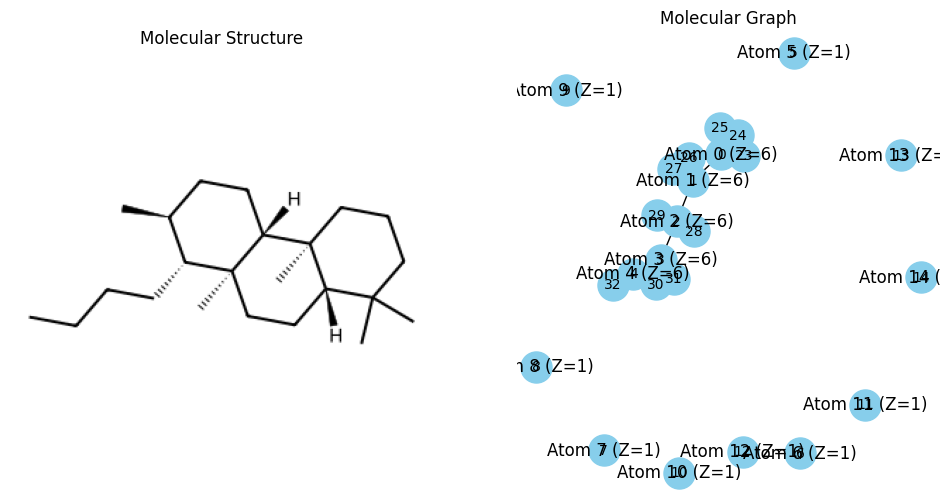

In [29]:
import matplotlib.pyplot as plt
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw

def draw_molecular_graph(molecule_smiles, graph_data):
    """
    Draw the molecular graph and visualize it using matplotlib and networkx.

    Parameters:
    molecule_smiles (str): SMILES string of the molecule.
    graph_data (torch_geometric.data.Data): Graph data object from PyTorch Geometric.

    Returns:
    None
    """
    # Convert the graph_data to a networkx graph for visualization
    G = nx.Graph()

    # Add nodes and their features
    for i, node_feature in enumerate(graph_data.x.tolist()):
        atomic_number = int(node_feature[0])  # Assuming atomic number is the first feature
        G.add_node(i, label=f"Atom {i} (Z={atomic_number})")

    # Add edges
    edge_index = graph_data.edge_index.numpy()
    for i in range(edge_index.shape[1]):
        start, end = edge_index[:, i]
        G.add_edge(start, end)

    # Draw the molecular structure using RDKit
    mol = Chem.MolFromSmiles(molecule_smiles)
    img = Draw.MolToImage(mol)

    # Plot the molecular structure
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Molecular Structure")

    # Plot the molecular graph
    plt.subplot(1, 2, 2)
    pos = nx.spring_layout(G)  # Position nodes using spring layout
    nx.draw(
        G, pos, with_labels=True, node_color="skyblue", node_size=500, font_size=10
    )
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'))
    plt.title("Molecular Graph")
    plt.show()


# Example usage
molecule_smiles = "CCCC[C@@H]1[C@@H](C)CC[C@H]2[C@@]1(C)CC[C@H]1C(C)(C)CCC[C@]21C"
draw_molecular_graph(molecule_smiles, graph_data)


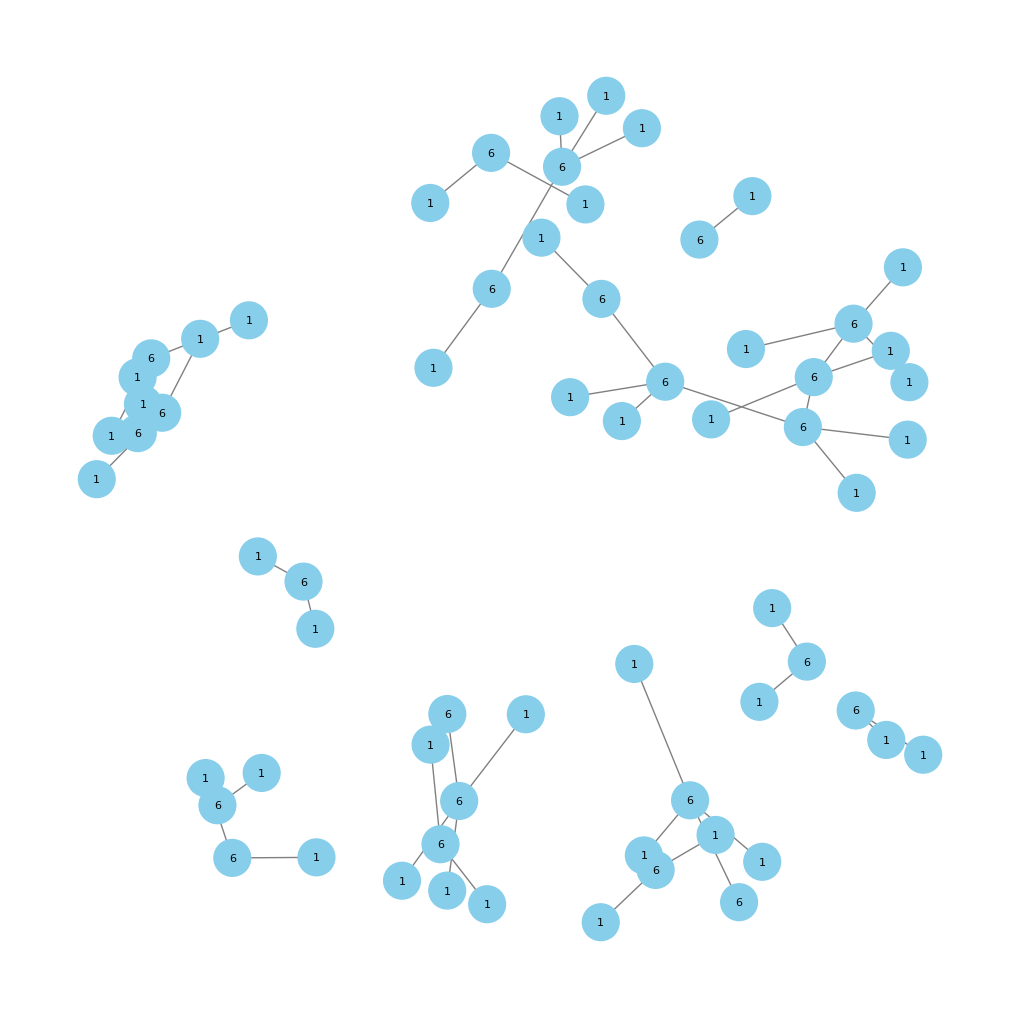

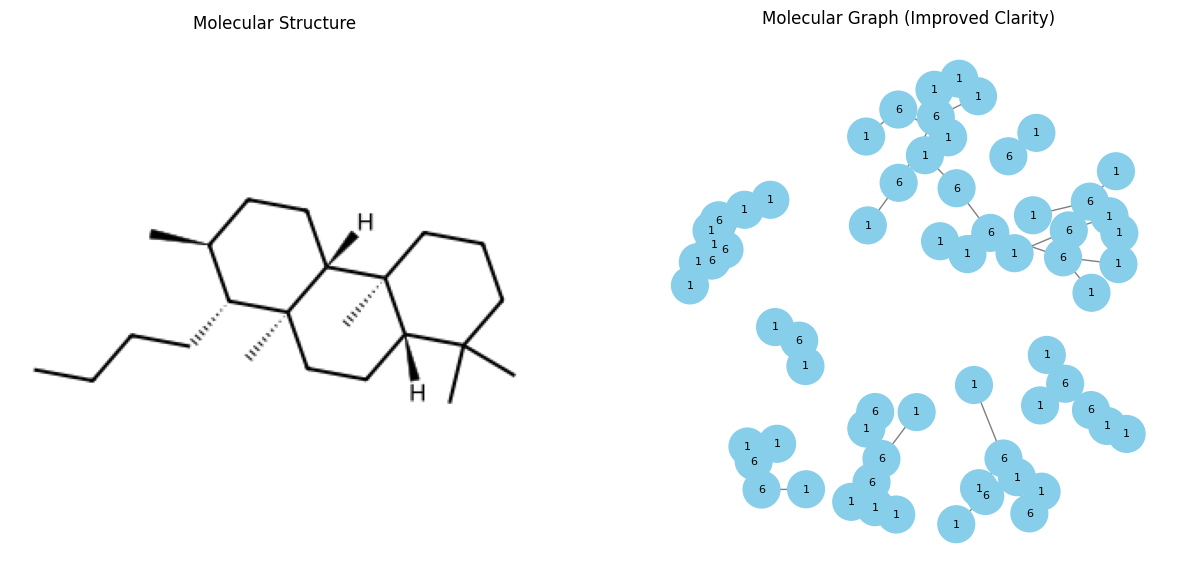

In [32]:
def draw_clear_molecular_graph(molecule_smiles, graph_data):
    """
    Draw the molecular graph with improved clarity using networkx and matplotlib.

    Parameters:
    molecule_smiles (str): SMILES string of the molecule.
    graph_data (torch_geometric.data.Data): Graph data object from PyTorch Geometric.

    Returns:
    None
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    from rdkit import Chem
    from rdkit.Chem import Draw

    # Convert the graph_data to a networkx graph
    G = nx.Graph()
    for i, node_feature in enumerate(graph_data.x.tolist()):
        atomic_number = int(node_feature[0])  # Assuming atomic number is the first feature
        G.add_node(i, label=f"{atomic_number}", color='skyblue')

    # Add edges
    edge_index = graph_data.edge_index.numpy()
    for i in range(edge_index.shape[1]):
        start, end = edge_index[:, i]
        G.add_edge(start, end)

    # Get node labels and colors
    labels = nx.get_node_attributes(G, "label")
    colors = [G.nodes[node].get("color", "skyblue") for node in G.nodes]

    # Improve node positions with spring layout
    pos = nx.spring_layout(G, k=0.3, iterations=50)  # Adjust 'k' for spacing

    # Plot the molecular graph
    plt.figure(figsize=(10, 10))
    nx.draw(
        G, pos, with_labels=True, labels=labels,
        node_color=colors, node_size=700, font_size=8, font_color="black", edge_color="gray"
    )

    # Draw the molecular structure using RDKit
    mol = Chem.MolFromSmiles(molecule_smiles)
    img = Draw.MolToImage(mol)

    # Combine molecular structure and graph visualization
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Molecular Structure")

    plt.subplot(1, 2, 2)
    nx.draw(
        G, pos, with_labels=True, labels=labels,
        node_color=colors, node_size=700, font_size=8, font_color="black", edge_color="gray"
    )
    plt.title("Molecular Graph (Improved Clarity)")
    plt.show()

# Example usage
molecule_smiles = "CCCC[C@@H]1[C@@H](C)CC[C@H]2[C@@]1(C)CC[C@H]1C(C)(C)CCC[C@]21C"
draw_clear_molecular_graph(molecule_smiles, graph_data)


In [33]:
# Filter bonds of type "C-C" from the DataFrame
cc_bonds = df[df['bond_type'] == 'C-C']

# Display all C-C bonds
print("All C-C bonds from DataFrame:")
print(cc_bonds[['start_atom_idx', 'end_atom_idx', 'bond_index']])

# Extract edges from the constructed graph
graph_edges = set(tuple(sorted(edge)) for edge in graph_data.edge_index.numpy().T)

# Find missing C-C bonds
missing_cc_bonds = []
for _, row in cc_bonds.iterrows():
    bond = tuple(sorted((row['start_atom_idx'], row['end_atom_idx'])))
    if bond not in graph_edges:
        missing_cc_bonds.append(bond)

# Display missing C-C bonds
if missing_cc_bonds:
    print("Missing C-C bonds:")
    for bond in missing_cc_bonds:
        print(f"Start: {bond[0]}, End: {bond[1]}")
else:
    print("No missing C-C bonds!")


All C-C bonds from DataFrame:
   start_atom_idx  end_atom_idx  bond_index
0               0             1           0
1               1             2           1
2               2             3           2
3               3             4           3
4               5             6           5
5              10            11          10
6              15            16          15
7              15            17          16
8              21            22          21
No missing C-C bonds!


In [34]:
for bond in molecule.molH.GetBonds():
    print(f"Bond {bond.GetIdx()}: Start Atom {bond.GetBeginAtomIdx()}, End Atom {bond.GetEndAtomIdx()}, Type {bond.GetBondType()}")


Bond 0: Start Atom 0, End Atom 1, Type SINGLE
Bond 1: Start Atom 1, End Atom 2, Type SINGLE
Bond 2: Start Atom 2, End Atom 3, Type SINGLE
Bond 3: Start Atom 3, End Atom 4, Type SINGLE
Bond 4: Start Atom 4, End Atom 5, Type SINGLE
Bond 5: Start Atom 5, End Atom 6, Type SINGLE
Bond 6: Start Atom 5, End Atom 7, Type SINGLE
Bond 7: Start Atom 7, End Atom 8, Type SINGLE
Bond 8: Start Atom 8, End Atom 9, Type SINGLE
Bond 9: Start Atom 9, End Atom 10, Type SINGLE
Bond 10: Start Atom 10, End Atom 11, Type SINGLE
Bond 11: Start Atom 10, End Atom 12, Type SINGLE
Bond 12: Start Atom 12, End Atom 13, Type SINGLE
Bond 13: Start Atom 13, End Atom 14, Type SINGLE
Bond 14: Start Atom 14, End Atom 15, Type SINGLE
Bond 15: Start Atom 15, End Atom 16, Type SINGLE
Bond 16: Start Atom 15, End Atom 17, Type SINGLE
Bond 17: Start Atom 15, End Atom 18, Type SINGLE
Bond 18: Start Atom 18, End Atom 19, Type SINGLE
Bond 19: Start Atom 19, End Atom 20, Type SINGLE
Bond 20: Start Atom 20, End Atom 21, Type SINGLE
